참고 : https://dschloe.github.io/python/python_edu/07_deeplearning/deep_learning_lstm/

## import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 불러오기

In [2]:
train_x_df = pd.read_csv('./open/train_x_df.csv')
train_y_df = pd.read_csv('./open/train_y_df.csv')
train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534


## 100번 샘플 테스트

In [3]:
sample_id = 100
X_train = train_x_df[train_x_df.sample_id==sample_id][['time', 'close']]
y_train = train_y_df[train_y_df.sample_id==sample_id][['time', 'close']]
X_train.index = X_train.time
y_train.index = y_train.time
X_train.head()

,time,close
time,,
0,0,0.944003
1,1,0.944115
2,2,0.944003
3,3,0.944563
4,4,0.944339


In [4]:
y_train.head()

,time,close
time,,
0,0,1.000112
1,1,1.000448
2,2,0.994736
3,3,0.998768
4,4,0.999440


## 시각화

In [5]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=X_train['close'], x=X_train['time'])
plt.xlabel('time')
plt.ylabel('price')

Text(0, 0.5, 'price')

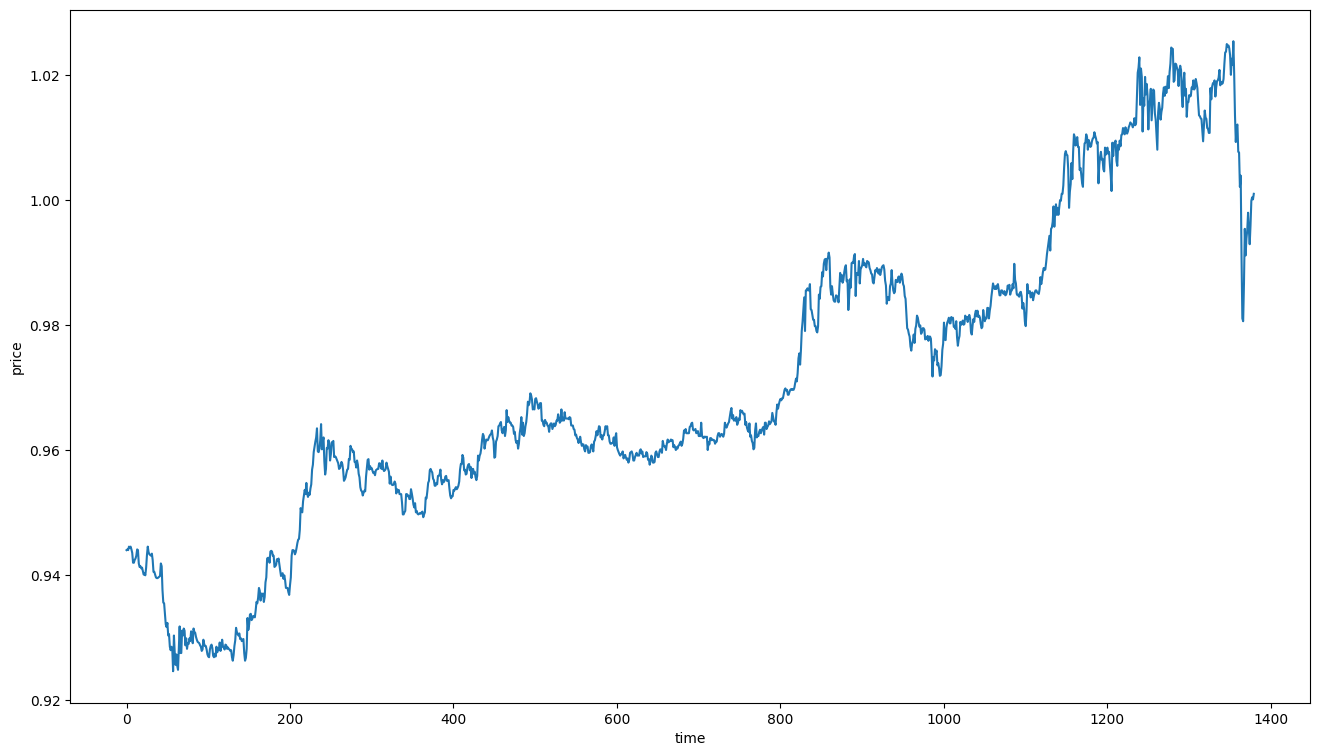

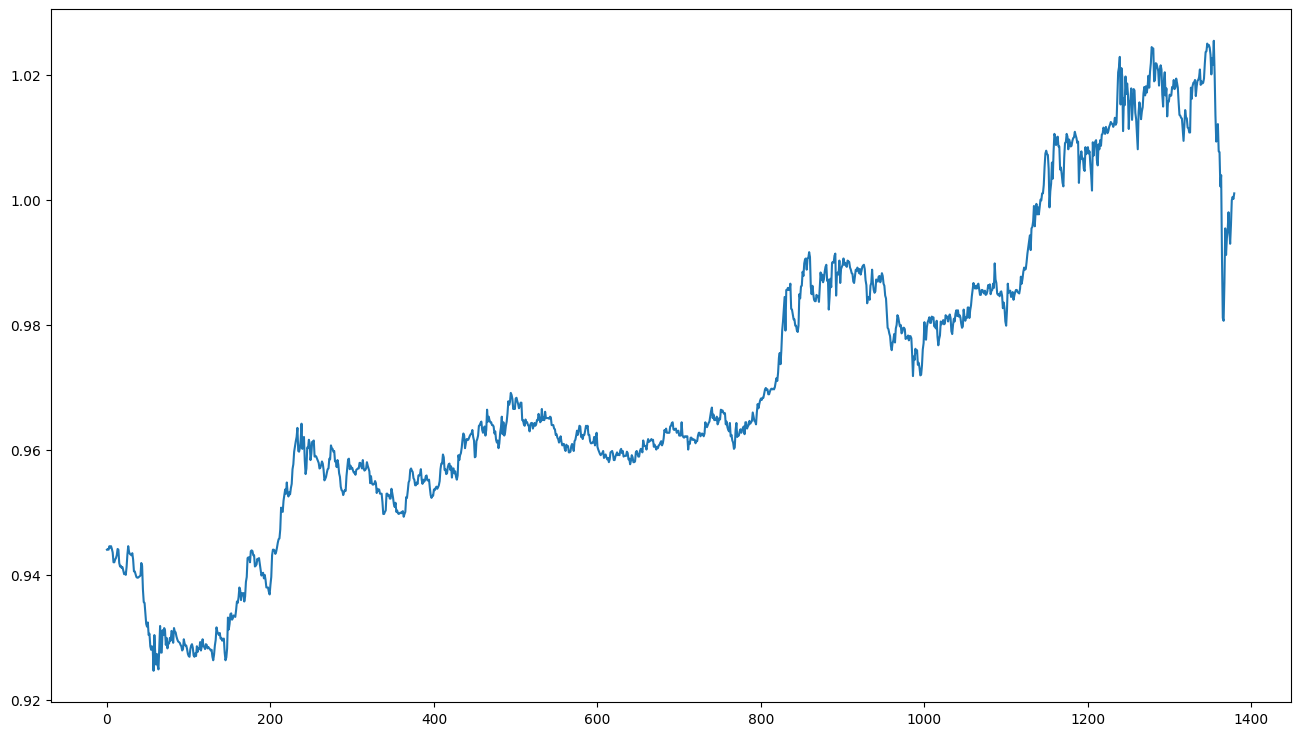

In [6]:
plt.figure(figsize=(16, 9))
plt.plot(X_train.time, X_train.close)
plt.show()

## 데이터 정규화

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
X_train.sort_index(ascending=False).reset_index(drop=True) # 0~1380

scaler = MinMaxScaler()
# scale_cols = ['time', 'close',] # 종가만 고려
scale_cols = ['close',]
df_scaled = scaler.fit_transform(X_train[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,close
0,0.192222
1,0.193332
2,0.192222
3,0.197777
4,0.195555
...,...
1375,0.707778
1376,0.746666
1377,0.752222
1378,0.748888


In [61]:
y_train.sort_index(ascending=False).reset_index(drop=True) # 0~120

scaler = MinMaxScaler()
# scale_cols = ['time', 'close',] # 종가만 고려
scale_cols = ['close',]
df_scaled_y = scaler.fit_transform(y_train[scale_cols])
df_scaled_y = pd.DataFrame(df_scaled_y)
df_scaled_y.columns = scale_cols

df_scaled_y

,close
0,0.893718
1,0.908213
2,0.661837
3,0.835748
4,0.864734
...,...
115,0.671499
116,0.618357
117,0.700485
118,0.714978


## 데이터셋 분리

In [58]:
# TEST_SIZE =  1380 # 1380분 학습
# WINDOW_SIZE = 120 # 120분 기반 예측

# train = df_scaled[:-TEST_SIZE] # -> X
# test = df_scaled_y[-TEST_SIZE:] # -> Y

In [11]:
def make_dataset(data, label, window_size=120):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[window_size]))
    return np.array(feature_list), np.array(label_list)

In [13]:
# train = df_scaled
train = X_train['close']

In [14]:
train

time
0       0.944003
1       0.944115
2       0.944003
3       0.944563
4       0.944339
          ...   
1375    0.995968
1376    0.999888
1377    1.000448
1378    1.000112
1379    1.001008
Name: close, Length: 1380, dtype: float64

In [16]:
test = y_train['close']

In [17]:
test

time
0      1.000112
1      1.000448
2      0.994736
3      0.998768
4      0.999440
         ...   
115    0.994960
116    0.993728
117    0.995632
118    0.995968
119    0.996416
Name: close, Length: 120, dtype: float64

훈련 데이터와 테스트 데이터 분리

In [15]:
from sklearn.model_selection import train_test_split

train_test_split(arrays, test_size, train_size, random_state, shuffle, stratify)
- arrays : 분할시킬 데이터
- test_size : 테스트 데이터셋의 비율(float)이나 갯수(int)
- train_size : 학습 데이터셋의 비율(float)이나 갯수(int)
- random_state : 데이터 분할시 셔플이 이루어지는데 이를 위한 시드값
- shuffle : 셔플여부설정
- stratify : 지정한 Data의 비율을 유지

RETURN
- X_train, X_test, Y_train, Y_test

?? 하나의 배열에서 train과 test를 분리하는 함수 => 필요 X

In [20]:
feature_cols = ['close']
label_cols = ['close']

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]

In [21]:
train_feature.shape, train_label.shape

In [51]:
train_feature, train_label = make_dataset(train_feature, train_label, 120)

In [22]:
train_feature, train_label = make_dataset(train, train, 20)

In [25]:
train_feature.shape

(1360, 20)

In [26]:
train_label.shape

(1360,)

In [27]:
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((1088, 20), (272, 20))

## 모형 학습
keras 모형 생성

In [53]:
# pip install keras

In [54]:
# pip install tensorflow

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[0], train_feature.shape[1]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

### 학습

In [29]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, # Training Data set
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), # Test Data Set
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200


ValueError: in user code:

    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (16, 20)


## 예측

In [40]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

ValueError: in user code:

    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\dvlprjw\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1)


In [41]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

NameError: name 'pred' is not defined